<div style="text-align: center;">
  <h1>TA145 - Redes Neuronales y Aprendizaje Profundo</h1>
  <h2>Trabajo Práctico 1: Red de Hopfield</h2>
</div>

---

<div style="text-align: left;">
  <h3><b>Ejercicio 1</b></h3>
</div>

Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.

&ensp; En primer lugar, se importan las librerías necesarias para el desarrollo del código implementado. Además, se definen las rutas relativas hacia las carpetas que contienen las imágenes de tamaños $50 \times 50$ y $60 \times 45$, que serán utilizadas a lo largo del trabajo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from PIL import Image
import os

path_50x50 = 'Images/50x50/'
path_60x45 = 'Images/60x45/'

&ensp; Luego, se realizan funciones para cargar y visualizar imágenes. La función $\texttt{load\_images}$ permite leer todas las imágenes de una carpeta y convertirlas en una lista de *arrays*, con la opción de redimensionarlas si se desea. Por otro lado, $\texttt{plot\_images}$ facilita la visualización de una lista de imágenes en una sola fila, mostrando cada imagen en escala de grises y sin ejes.

In [ ]:
def load_images(folder_path, resize=None) -> list[np.ndarray]:
    """Loads BMP images from a specified folder and returns them as a list of numpy arrays."""
    if folder_path is None or not os.path.isdir(folder_path):
        raise ValueError("Invalid folder path.")
    
    images = []
    for image_name in os.listdir(folder_path):
        if image_name.lower().endswith('.bmp'):
            image_path = os.path.join(folder_path, image_name)
            with Image.open(image_path) as img:
                if resize:
                    img = img.resize(resize)
                images.append(np.array(img))
    
    return images

def plot_images(images) -> None:
    """
    Plots a list of images in a single row.
    """
    if (len(images) == 0):
        raise ValueError("No images to display.")

    elif (len(images) == 1):
        plt.figure(figsize=(3.5, 5))
        plt.imshow(images[0], cmap='gray')
        plt.axis('off')

    else:
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
        for i, ax in enumerate(axes):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

&ensp; A continuación, se cargan las imágenes desde las rutas definidas y se visualizan para verificar su correcto procesamiento. Estas funciones permiten preparar y revisar los datos de entrada antes de entrenar y evaluar la Red de Hopfield, asegurando que las imágenes se encuentren en el formato y tamaño esperado.

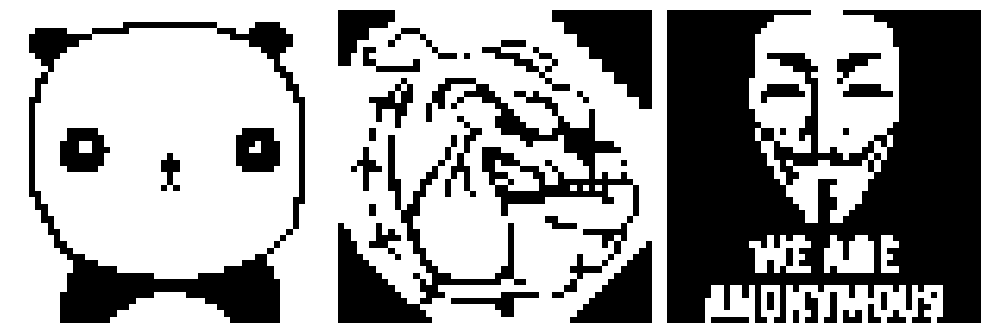

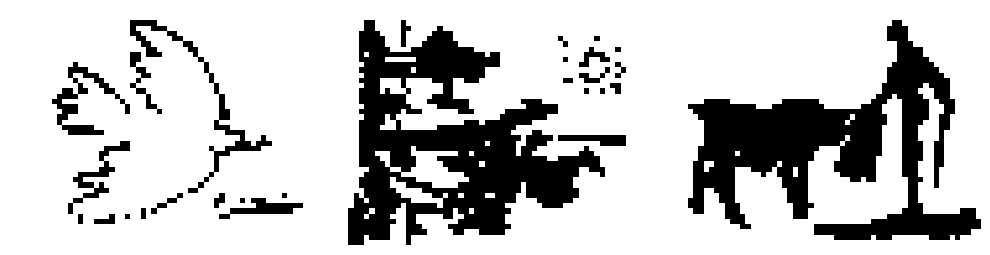

In [4]:
images_50x50 = load_images(path_50x50)
plot_images(images_50x50)

images_60x45 = load_images(path_60x45)
plot_images(images_60x45)

&ensp; Una vez cargadas las imágenes, se implementa la clase $\texttt{HopfieldNetwork}$, que permite entrenar patrones binarios y recuperar imágenes a partir de entradas parciales o ruidosas. La clase incluye los siguientes métodos principales:

- $\texttt{\_\_init\_\_}$: Inicializa los atributos de la red, incluyendo los pesos, la cantidad de neuronas y el número de iteraciones realizadas durante la predicción.

- $\texttt{\_preprocess\_patterns(patterns)}$: Convierte los patrones de entrada de valores binarios: $0$ y $1$, a valores centrados alrededor del cero: $-1$ y $1$. Esto es requerido por la Red de Hopfield, ya que, esta funciona de manera más eficiente con valores simétricos.  
  
\begin{align*}
  S_i = 2 \cdot \text{pattern}_i - 1 \Longrightarrow 
  \begin{cases} 
  -1 & \text{si } \text{pattern}_i = 0  \\
  1 & \text{si } \text{pattern}_i = 1
  \end{cases}
\end{align*}

- $\texttt{train(patterns)}$: Entrena la red utilizando el aprendizaje Hebbiano propio de la Red de Hopfield. En primer lugar convierte los patrones a $-1$ y $1$ con el método $\texttt{\_preprocess\_patterns}$, luego calcula la matriz de pesos según:  
  \begin{align*}
    W = \frac{1}{P} \sum_{p=1}^{P} \mathbf{S}_p \mathbf{S}_p^T, \quad \text{con } \text{diag}(W) = 0
  \end{align*}
  donde $P$ es el número de patrones y $\mathbf{S}_p$ es el patrón aplanado.

- $\texttt{predict(test\_pattern)}$: Dada una entrada (completa, parcial o ruidosa), recupera el patrón más cercano almacenado en la red. Actualiza las neuronas de forma asincrónica y aleatoria hasta que se alcance un estado estable:
  \begin{align*}
    S_i^{\text{current}} = \text{sgn}\left(\sum_{j = 0}^N W_{ij} S_j^{\text{previous}}\right)
  \end{align*}
  donde $N$ es el número de neuronas.

- $\texttt{predict\_multiple(test\_patterns, size)}$: Aplica el método $\texttt{predict}$ a múltiples patrones de entrada (listas de arrays) y devuelve los resultados con la forma original de cada imagen.

In [ ]:
class HopfieldNetwork:

    def __init__(self):
        self.weights = None
        self.n_neurons = None
        self.iterations = 0

    def _preprocess_patterns(self, patterns) -> np.ndarray:
        """
        Preprocesses the input patterns for the Hopfield network.
        """
        images_hopfield = [np.where(2 * patterns[i] - 1 >= 0, 1, -1) for i in range(len(patterns))]
        return np.array(images_hopfield)

    def train(self, patterns) -> None:
        """
        Trains the Hopfield network on a set of binary patterns (0/1).
        Converts them to -1/1 and updates the weights using Hebbian learning.
        """
        if patterns is None:
            raise ValueError("Input patterns cannot be None")

        if not isinstance(patterns, list):
            raise ValueError("Input patterns must be a list")

        hopfield_pattern = self._preprocess_patterns(patterns)
        n_patterns = hopfield_pattern.shape[0]
        
        neurons = hopfield_pattern.reshape(n_patterns, -1)
        self.n_neurons = neurons.shape[1]

        self.weights = (neurons.T @ neurons) / n_patterns
        np.fill_diagonal(self.weights, 0)

    def predict(self, test_pattern) -> np.ndarray:
        """
        Predicts the output of the Hopfield network for a given input pattern.
        """
        if test_pattern is None:
            raise ValueError("Input pattern cannot be None")

        if not isinstance(test_pattern, (np.ndarray, list)):
            raise ValueError("Input pattern must be a numpy array or a list")
        
        hopfield_test_pattern = self._preprocess_patterns(test_pattern)
        current_neurons = hopfield_test_pattern.reshape(-1)
        previous_neurons = np.zeros_like(current_neurons)
        
        self.iterations = 0
        while not np.array_equal(current_neurons, previous_neurons):
            previous_neurons = current_neurons
            idx = np.random.permutation(self.n_neurons)
            for i in idx:
                current_neurons[i] = np.where(self.weights[i] @ previous_neurons.T >= 0, 1, -1)

            self.iterations += 1

        return current_neurons

    def predict_multiple(self, test_patterns, size) -> list[np.ndarray]:
        """
        Predicts the output of the Hopfield network for multiple input patterns of a given size.
        """
        if test_patterns is None:
            raise ValueError("Input patterns cannot be None")

        if not isinstance(test_patterns, list):
            raise ValueError("Input patterns must be a list")

        predictions = []
        for pattern in test_patterns:
            prediction = self.predict(pattern)
            predictions.append(prediction.reshape(size))
        
        return predictions

**(A)** Verifique si la red aprendió las imágenes enseñadas.

In [6]:
def calculate_accuracy(original, predicted) -> list[float]:
    """
    Calculates the accuracy of the Hopfield network's predictions.
    """
    if original is None or predicted is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(original, list) or not isinstance(predicted, list):
        raise ValueError("Input patterns must be lists")

    if len(original) != len(predicted):
        raise ValueError("Input patterns must have the same length")

    original = [np.where(2 * original[i] - 1 >= 0, 1, -1) for i in range(len(original))] # Convert to -1 & 1

    accuracy = []
    for i in range(len(original)):
        if original[i].shape != predicted[i].shape:
            raise ValueError("All patterns must have the same shape")

        accuracy.append(np.mean(original[i] == predicted[i]))

    return accuracy


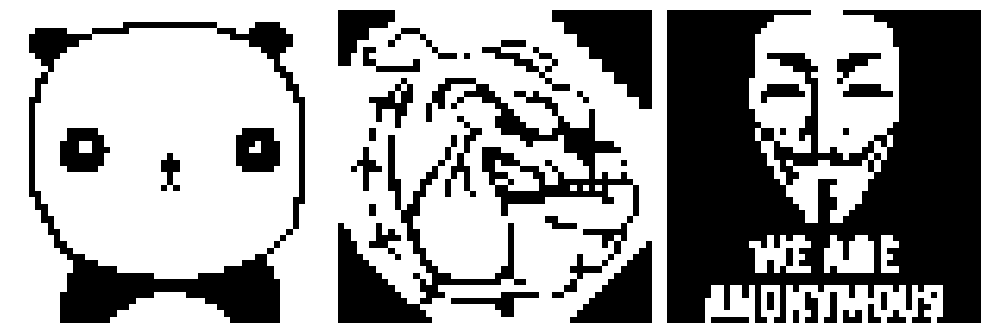

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
HN_50x50 = HopfieldNetwork()
HN_50x50.train(images_50x50)
predicted_50x50 = HN_50x50.predict_multiple(images_50x50, (50, 50))

plot_images(predicted_50x50)

accuracies_50x50 = calculate_accuracy(images_50x50, predicted_50x50)
for i, acc in enumerate(accuracies_50x50):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

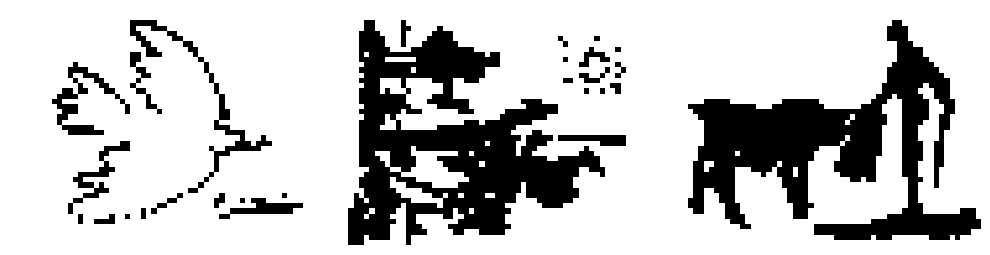

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
HN_60x45 = HopfieldNetwork()
HN_60x45.train(images_60x45)
predicted_60x45 = HN_60x45.predict_multiple(images_60x45, (45, 60)) #60x45 means 45 rows & 60 columns

plot_images(predicted_60x45)

accuracies_60x45 = calculate_accuracy(images_60x45, predicted_60x45)
for i, acc in enumerate(accuracies_60x45):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

**(B)** Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes
aprendidas: agregado de ruido, elementos borrados o agregados.

In [9]:
def generate_noise(images, noise_level) -> list[np.ndarray]:
    """Generates random noise to add to the images."""
    
    noisy_images = []
    for img in images:
        noise = np.random.binomial(1, 1 - noise_level, img.shape)
        noisy_images.append(img * noise)
    
    return noisy_images

In [10]:
def erase_images(images, erase_percentage) -> list[np.ndarray]:
    """
    Erases a square block of pixels from each image according to the given erase percentage.
    """
    erased_images = []
    
    for img in images:
        m, n = img.shape
        block_size = int(np.sqrt(erase_percentage * m * n))

        block_size = min(block_size, m, n) # Block size should not exceed image dimensions
        max_x = m - block_size
        max_y = n - block_size

        start_x = np.random.randint(0, max_x + 1)
        start_y = np.random.randint(0, max_y + 1)
        
        img = img.astype(float)
        img[start_x:start_x + block_size, start_y:start_y + block_size] = 0.5

        erased_images.append(img)
    
    return erased_images

In [11]:
def plot_accuracy_variation(model, original, noise_bool, noise_levels, size) -> None:
    """
    Plots the accuracy variation of the model for different noise/erasure/spurious levels.
    """
    accuracies = []
    for noise in noise_levels:
        if noise_bool:
            noisy_images = generate_noise(original, noise)
        else:
            noisy_images = erase_images(original, noise)
        
        predictions = model.predict_multiple(noisy_images, size)
        accuracy = calculate_accuracy(original, predictions)
        accuracies.append(accuracy)

    legends = [f'Imagen {i+1}' for i in range(len(original))]
    plt.plot(noise_levels, accuracies, label=legends)
    if noise_bool:
        plt.title('Model Accuracy Variation with Noise Level')
        plt.xlabel('Noise Level')
    else:
        plt.title('Model Accuracy Variation with Erasure Level')
        plt.xlabel('Erasure Level')
        
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

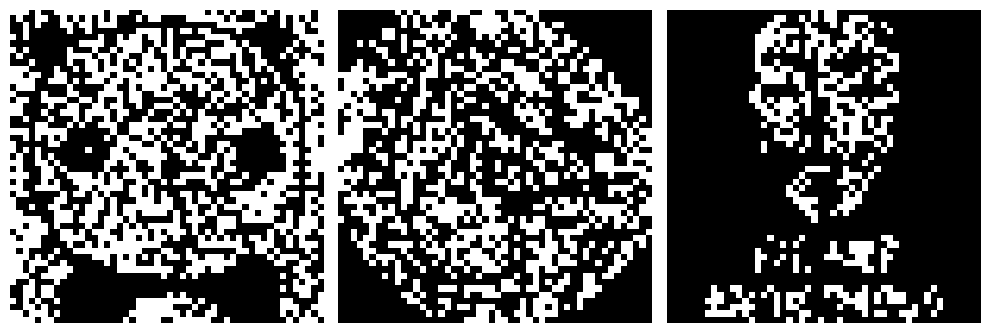

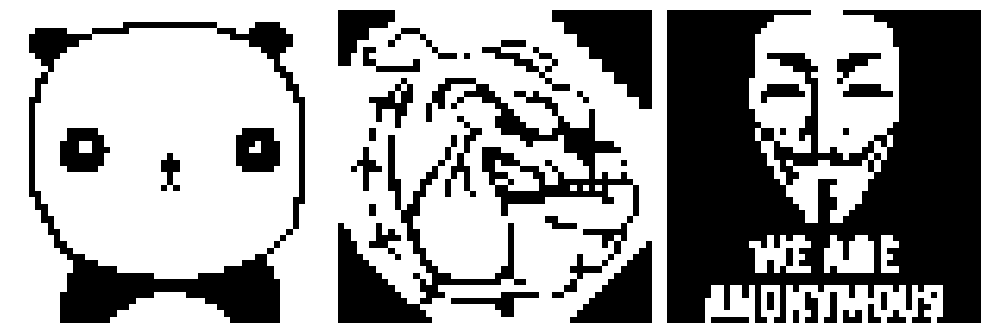

In [12]:
images_50x50_noisy = generate_noise(images_50x50, noise_level=0.45)
plot_images(images_50x50_noisy)

predicted_50x50_noisy = HN_50x50.predict_multiple(images_50x50_noisy, (50, 50))
plot_images(predicted_50x50_noisy)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

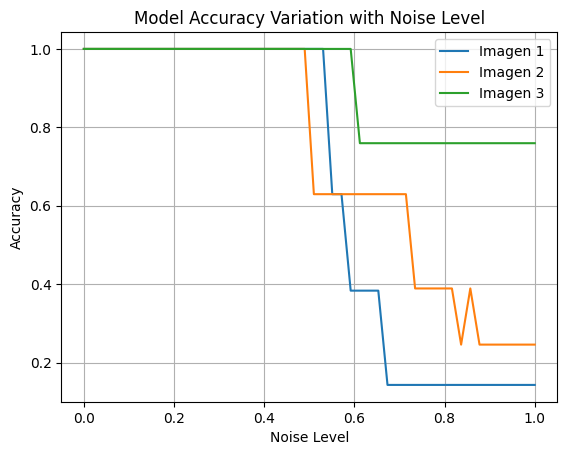

In [13]:
accuracies_50x50_noisy = calculate_accuracy(images_50x50, predicted_50x50_noisy)
for i, acc in enumerate(accuracies_50x50_noisy):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

noise_levels = np.linspace(0, 1, 50)
plot_accuracy_variation(HN_50x50, images_50x50, noise_bool=True, noise_levels=noise_levels, size=(50, 50))

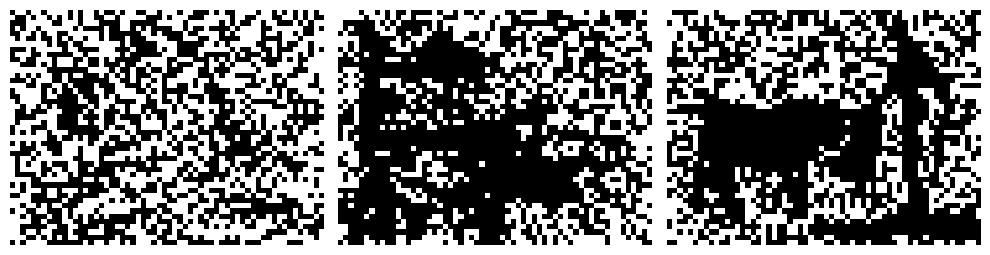

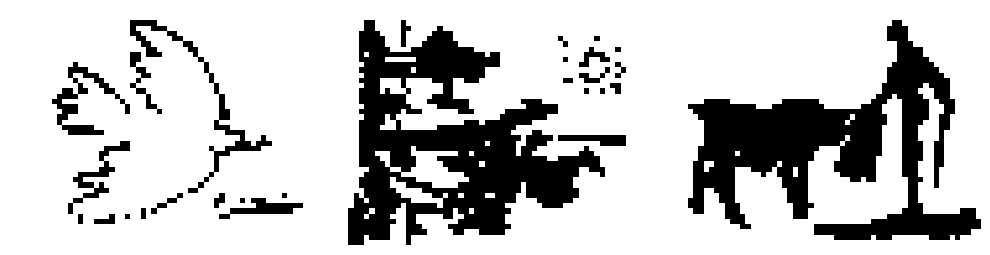

In [14]:
images_60x45_noisy = generate_noise(images_60x45, noise_level=0.45)
plot_images(images_60x45_noisy)

predicted_60x45_noisy = HN_60x45.predict_multiple(images_60x45_noisy, (45, 60))
plot_images(predicted_60x45_noisy)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

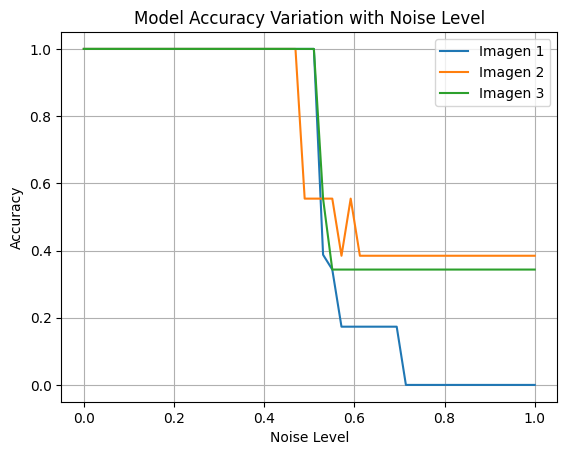

In [15]:
accuracies_60x45_noisy = calculate_accuracy(images_60x45, predicted_60x45_noisy)
for i, acc in enumerate(accuracies_60x45_noisy):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

plot_accuracy_variation(HN_60x45, images_60x45, noise_bool=True, noise_levels=noise_levels, size=(45, 60))

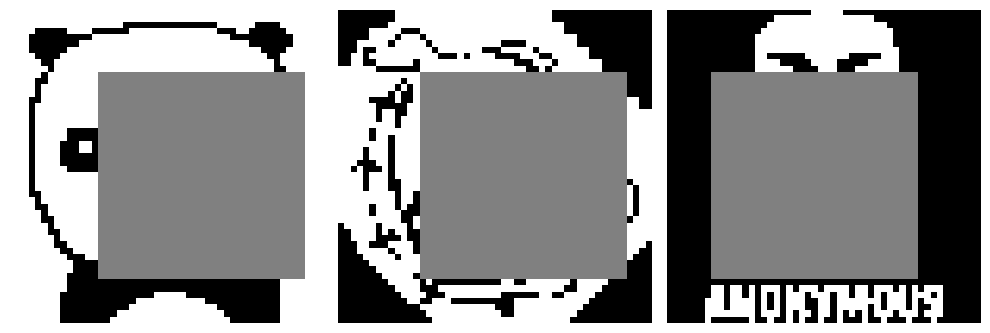

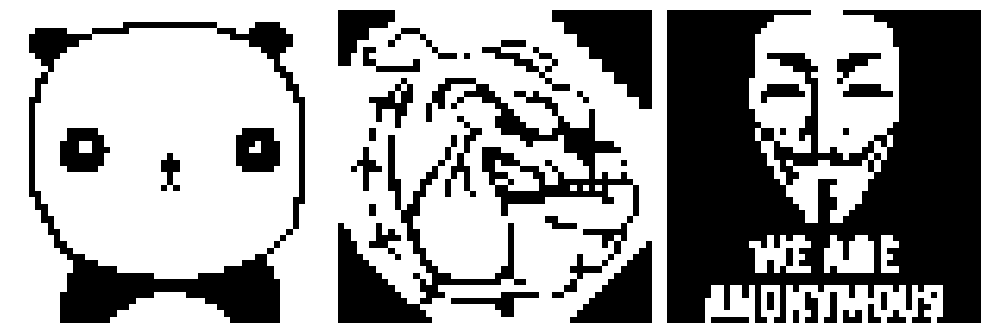

In [16]:
images_50x50_erased = erase_images(images_50x50, erase_percentage=0.45)
plot_images(images_50x50_erased)

predicted_50x50_erased = HN_50x50.predict_multiple(images_50x50_erased, (50, 50))
plot_images(predicted_50x50_erased)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

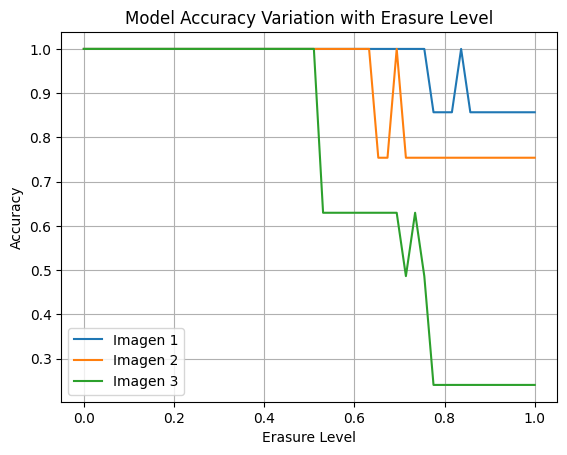

In [17]:
accuracies_50x50_erased = calculate_accuracy(images_50x50, predicted_50x50_erased)
for i, acc in enumerate(accuracies_50x50_erased):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

plot_accuracy_variation(HN_50x50, images_50x50, noise_bool=False, noise_levels=noise_levels, size=(50, 50))

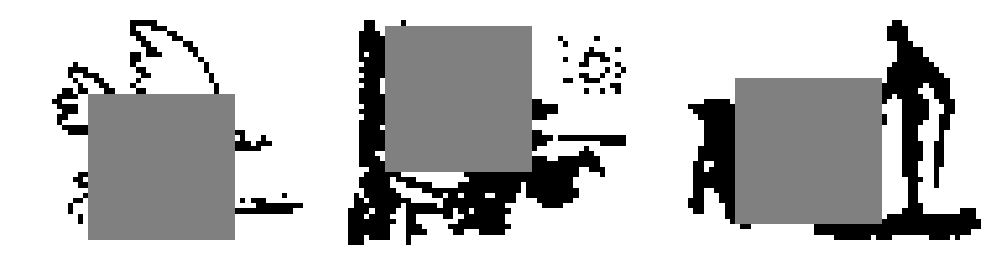

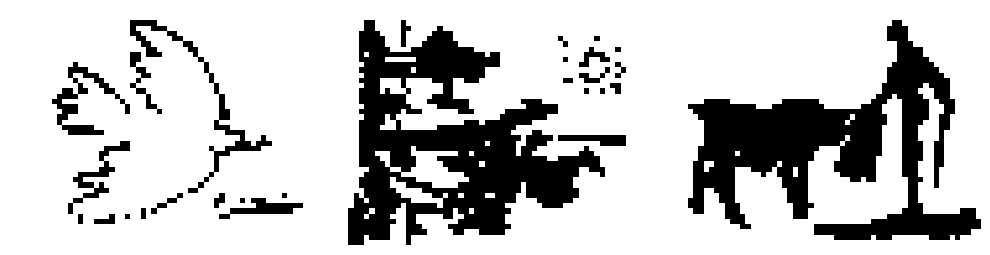

In [18]:
images_60x45_erased = erase_images(images_60x45, erase_percentage=0.3)
plot_images(images_60x45_erased)

predicted_60x45_erased = HN_60x45.predict_multiple(images_60x45_erased, (45, 60))
plot_images(predicted_60x45_erased)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

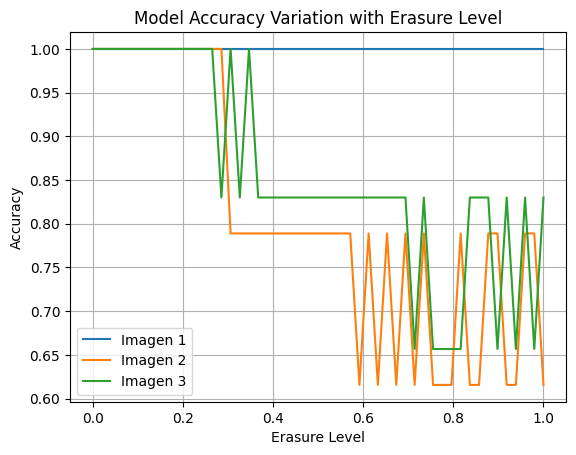

In [19]:
accuracies_60x45_erased = calculate_accuracy(images_60x45, predicted_60x45_erased)
for i, acc in enumerate(accuracies_60x45_erased):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

plot_accuracy_variation(HN_60x45, images_60x45, noise_bool=False, noise_levels=noise_levels, size=(45, 60))

**(C)** Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. (Ver *Spurious States, sección $2.2$, Hertz, Krogh & Palmer, pág. $24$*).

In [20]:
def generate_inverse_spurious_states(patterns) -> list[np.ndarray]:
    """
    Generates inverse spurious states for a set of patterns.
    """
    if patterns is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(patterns, list):
        raise ValueError("Input patterns must be a list")

    hoppfield_inverse_pattern = [np.where(2 * patterns[i] - 1 >= 0, -1, 1) for i in range(len(patterns))]
    return hoppfield_inverse_pattern


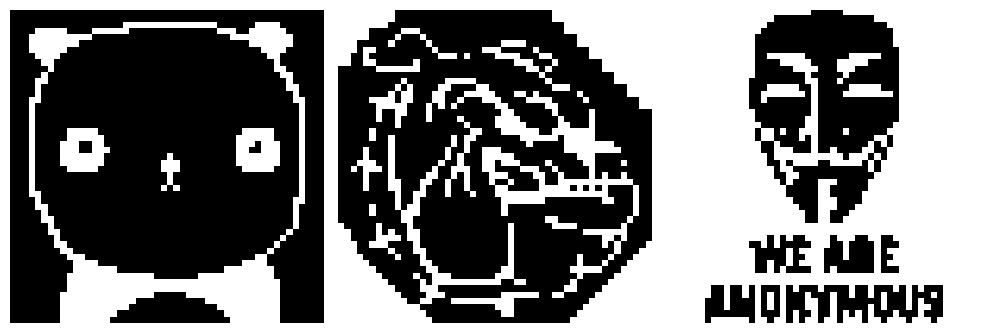

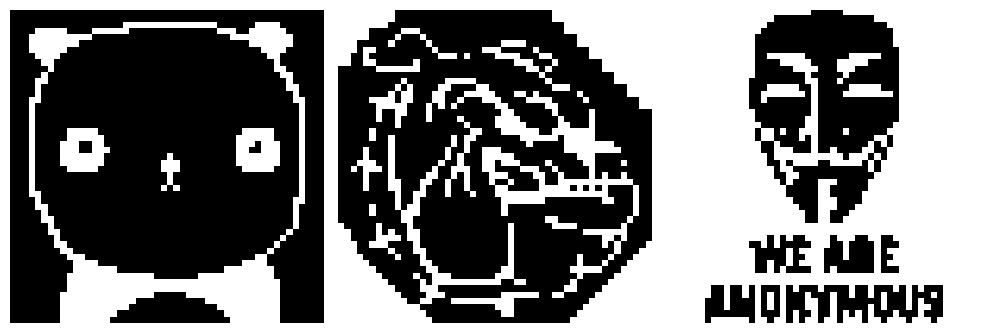

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [21]:
inverse_images_50x50 = generate_inverse_spurious_states(images_50x50)
plot_images(inverse_images_50x50)

predicted_50x50_inverse = HN_50x50.predict_multiple(inverse_images_50x50, (50, 50))
plot_images(predicted_50x50_inverse)

accuracies_50x50_inverse = calculate_accuracy(inverse_images_50x50, predicted_50x50_inverse)
for i, acc in enumerate(accuracies_50x50_inverse):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

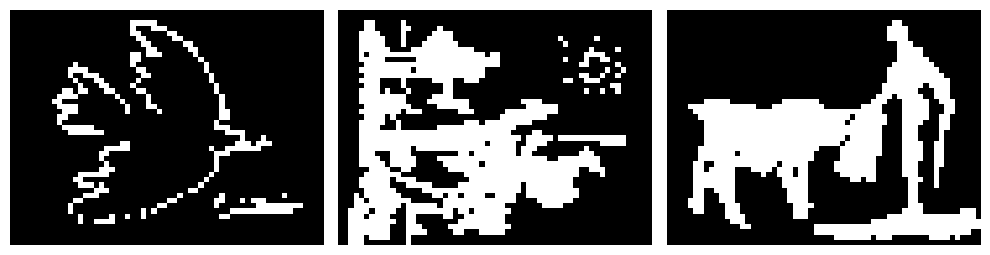

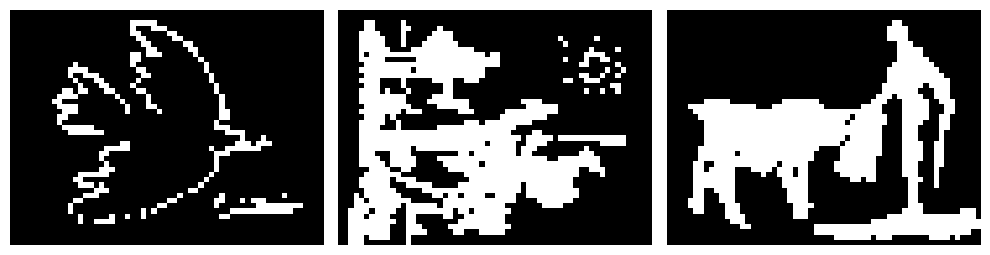

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
inverse_images_60x45 = generate_inverse_spurious_states(images_60x45)
plot_images(inverse_images_60x45)

predicted_60x45_inverse = HN_60x45.predict_multiple(inverse_images_60x45, (45, 60))
plot_images(predicted_60x45_inverse)

accuracies_60x45_inverse = calculate_accuracy(inverse_images_60x45, predicted_60x45_inverse)
for i, acc in enumerate(accuracies_60x45_inverse):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

In [23]:
def combination_spurious_states(patterns, n_comb) -> list[np.ndarray]:
    """
    Generates a spurious state by combining n_comb random patterns (n_comb must be odd).
    Returns a list with a single combined pattern (for plotting compatibility).
    """
    if patterns is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(patterns, list):
        raise ValueError("Input patterns must be a list")

    if n_comb % 2 == 0:
        raise ValueError("n_comb must be an odd number")
    n_patterns = len(patterns)

    replace = n_patterns < n_comb # If n_patterns < n_comb, allow replacement
    index = np.random.choice(n_patterns, n_comb, replace=replace)
    
    hopfield_patterns = [np.where(2 * patterns[i] - 1 >= 0, 1, -1) for i in index]
    combined = np.sum(hopfield_patterns, axis=0)
    combined = np.where(combined >= 0, 1, -1)
    
    return [combined]

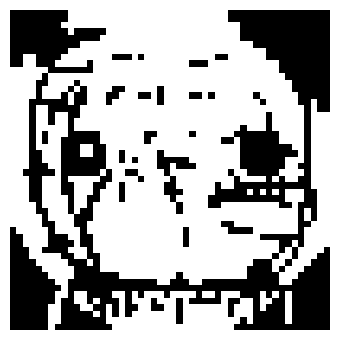

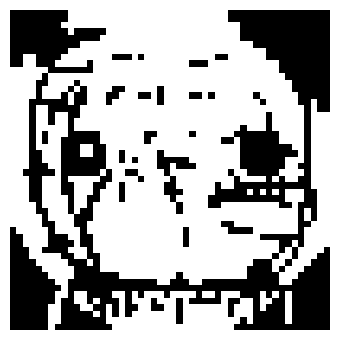

<IPython.core.display.Latex object>

In [24]:
combinated_images_50x50 = combination_spurious_states(images_50x50, 3)
plot_images(combinated_images_50x50)

predicted_50x50_combinated = HN_50x50.predict_multiple(combinated_images_50x50, (50, 50))
plot_images(predicted_50x50_combinated)

accuracies_50x50_combinated = calculate_accuracy(combinated_images_50x50, predicted_50x50_combinated)
display(Latex(rf"$\text{{Imagen}}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

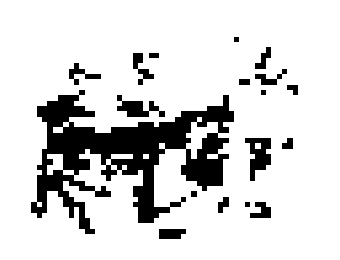

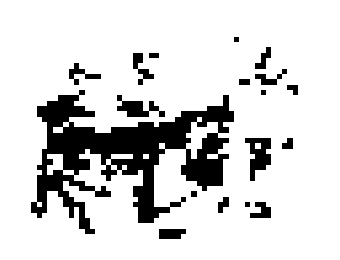

<IPython.core.display.Latex object>

In [25]:
combinated_images_60x45 = combination_spurious_states(images_60x45, 3)
plot_images(combinated_images_60x45)

predicted_60x45_combinated = HN_60x45.predict_multiple(combinated_images_60x45, (45, 60))
plot_images(predicted_60x45_combinated)

accuracies_60x45_combinated = calculate_accuracy(combinated_images_60x45, predicted_60x45_combinated)
display(Latex(rf"$\text{{Imagen}}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

**(D)** Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

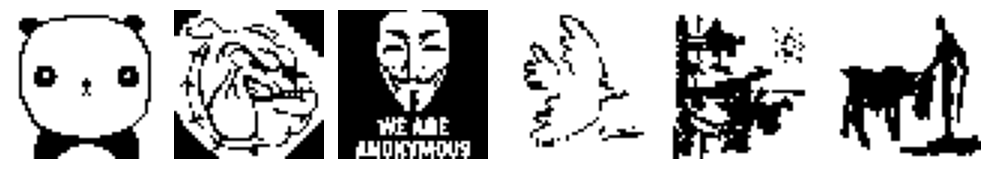

In [26]:
images_60x45_resized = load_images(path_60x45, resize=(50, 50))
all_images = images_50x50 + images_60x45_resized

plot_images(all_images)

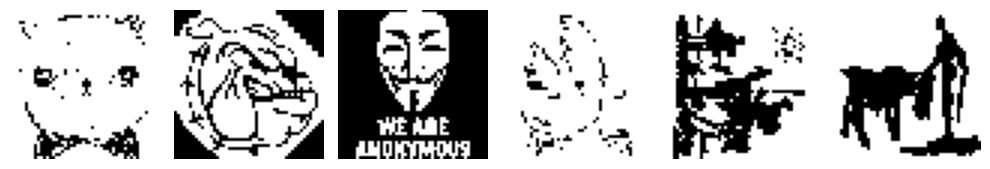

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [27]:
HN_all = HopfieldNetwork()
HN_all.train(all_images)
predicted_all = HN_all.predict_multiple(all_images, (50, 50))

plot_images(predicted_all)

accuracies_all = calculate_accuracy(all_images, predicted_all)
for i, acc in enumerate(accuracies_all):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

---

<div style="text-align: left;">
  <h3><b>Ejercicio 2</b></h3>
</div>

**(A)** Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red. Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).

<center>

| $P_{\text{error}}$ | $\frac{p_{\text{max}}}{N}$ |
|--------|--------|
| 0,001  | 0,105  |
| 0,0036 | 0,138  |
| 0,01   | 0,185  |
| 0,05   | 0,37   |
| 0,1    | 0,61   |

(*Tabla $2.1$, sección $2.2$, Hertz, Krogh & Palmer, pág. $19$*)

</center>



**(B).** Proponer una manera de generar patrones con distintos grados de correlación. Utilice el método propuesto para analizar cómo varía la capacidad de la red de Hopfield en función de la correlación entre patrones.